<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/2019%20Fastai%20Deep%20Learning/2019_Deep_Learning_7_Camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 8.09 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
path = Path('/content/SegNet-Tutorial/CamVid')

In [5]:
path.ls()

[PosixPath('/content/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot')]

In [6]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07959.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07983.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08077.png')]

In [7]:
lbl_names = get_image_files(path/'valannot')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07959.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07983.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08077.png')]

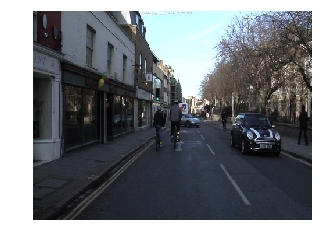

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

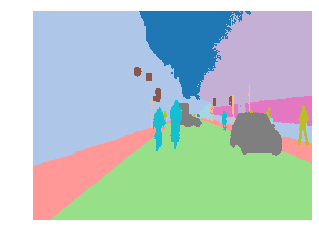

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[:1])
src_size,mask.data

(array([1]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

#U-Net [30:16](https://youtu.be/nWpdkZE2_cc?t=1816)

That's ResNets. One of the main reasons other than the fact that ResNets are awesome to tell you about them is that these **skipped connections are useful in other places as well**. They are particularly useful in other places in other ways of designing architectures for segmentation. So in building this lesson, I keep trying to take old papers and imagining like what would that person have done if they had access to all the modern techniques we have now, and I try to rebuild them in a more modern style. So I've been really rebuilding this next architecture we're going to look at called U-Net in a more modern style recently, and got to the point now I keep showing you this semantic segmentation paper with the state of the art for CamVid which was 91.5.

![alt text](https://github.com/hiromis/notes/blob/master/lesson7/14.png?raw=true)

This week, I got it up to 94.1 using the architecture I'm about to show you. So we keep pushing this further and further and further. And it's really it was all about adding all of the modern tricks - many of which I'll show you today, some of which we will see in part 2.

What we're going to do to get there is we're going to use this U-Net. We've used a U-Net before. We used it when we did the CamVid segmentation but we didn't understand what it was doing. So we're now in a position where we can understand what it was doing. 

**The first thing we need to do is to understand the basic idea of how you can do segmentation**. If we go back to our CamVid notebook, in our [CamVid notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid-tiramisu.ipynb) you'll remember that basically what we were doing is we were taking these photos and adding a class to every single pixel.



In [0]:
bs,size = 8,src_size//2

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn,classes=codes))

In [0]:
data = (src.transform(get_transforms(),tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

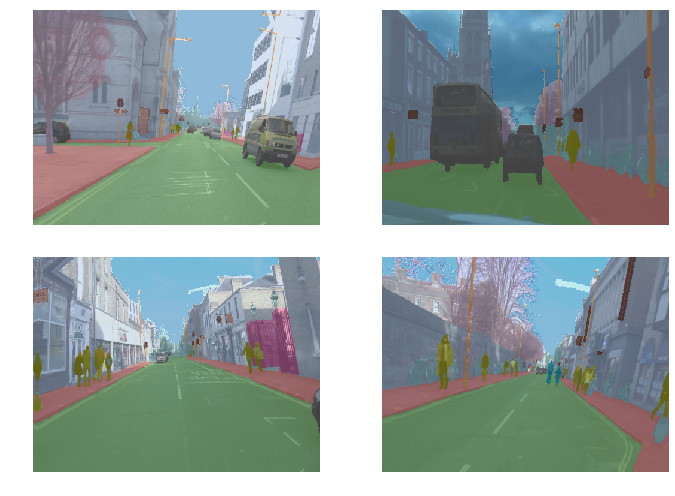

In [15]:
data.show_batch(2,figsize=(10,7))

So when you go **data.show_batch** for something which is a SegmentationItemList, it will automatically show you these color-coded pixels.

[32:35](https://youtu.be/nWpdkZE2_cc?t=1955)

Here's the thing. In order to color code this as a pedestrian, but this as a bicyclist, it needs to know what it is. It needs to actually know that's what a pedestrian looks like, and it needs to know that's exactly where the pedestrian is, and this is the arm of the pedestrian and not part of their shopping basket. It needs to really understand a lot about this picture to do this task, and it really does do this task. When you looked at the results of our top model, I can't see a single pixel by looking at it by eye, I know there's a few wrong, but I can't see the ones that are wrong. It's that accurate. So how does it do that? **-> how it know how to differentiate objects?**

**The way that we're doing it to get these really really good results is not surprisingly using pre-training.**



In [16]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'Building': 1,
 'Car': 8,
 'Cyclist': 10,
 'Fence': 7,
 'Pedestrian': 9,
 'Pole': 2,
 'Road': 3,
 'Sidewalk': 4,
 'Sign': 6,
 'Sky': 0,
 'Tree': 5,
 'Void': 11}

In [0]:
void_code = name2id['Void']

In [0]:
def acc_camvid(input,target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics = acc_camvid
metrics

<function __main__.acc_camvid>

In [0]:
wd = 1e-2

In [21]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 161354658.61it/s]


So we start with a ResNet 34 and you can see that here **unet_learner(data, models.resnet34,...)**. If you don't say pretrained=False , by default, you get pretrained=True because ... why not?

![alt text](https://github.com/hiromis/notes/blob/master/lesson7/16.png?raw=true)

We start with a ResNet 34 which starts with a big image. In this case, this is from the U-Net paper. Their images, they started with one channel by 572 by 572. This is for medical imaging segmentation. After your stride 2 conv, they're doubling the number of channels to 128, and they're halving the size so they're now down to 280 by 280. In this original unit paper, they didn't add any padding. So they lost a pixel on each side each time they did a conv. That's why you are losing these two. But basically half the size, and then half the size, and then half the size, and then half the size, until they're down to 28 by 28 with 1024 channels.

So that's what the U-Net's downsampling path (the left half is called the downsampling path) look like. Ours is just a ResNet 34. So you can see it here **learn.summary()**, this is literally a ResNet 34. So you can see that the size keeps halving, channels keep going up and so forth.

In [22]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
______________________________________________________________

Eventually, you've got down to a point where, if you use U-Net architecture, it's 28 by 28 with 1,024 channels. With the ResNet architecture with a 224 pixel input, it would be 512 channels by 7 by 7. So it's a pretty small grid size on this feature map. Somehow, we've got to end up with something which is the same size as our original picture. So how do we do that? How do you do computation which increases the grid size? Well, we don't have a way to do that in our current bag of tricks. We can use a stride one conv to do computation and keeps grid size or a stride 2 conv to do computation and halve the grid size.

[35:58](https://youtu.be/nWpdkZE2_cc?t=2158)

So how do we double the grid size? We do a **stride half conv**, also known as a **deconvolution**, also known as a **transpose convolution**.

![alt text](https://github.com/hiromis/notes/blob/master/lesson7/17.png?raw=true)

There is a fantastic paper called [A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) that shows a great picture of exactly what does a 3x3 kernel stride half conv look like. And it's literally this. If you have a 2x2 input, so the blue squares are the 2x2 input, you add not only 2 pixels of padding all around the outside, but you also add a pixel of padding between every pixel. So now if we put this 3x3 kernel here, and then here, and then here, you see how the 3x3 kernels just moving across it in the usual way, you will end up going from a 2x2 output to a 5x5 output. If you only added one pixel of padding around the outside, you would end up with a 4x4 output.

This is how you can increase the resolution. This was the way people did it until maybe a year or two ago. There's another trick for improving things you find online. Because this is actually a dumb way to do it. And it's kind of obvious it's a dumb way to do it for a couple of reasons. One is that, have a look at the shaded area on the left, nearly all of those pixels are white. They're nearly all zeros. What a waste. What a waste of time, what a waste of computation. There's just nothing going on there.

![](https://github.com/hiromis/notes/raw/master/lesson7/18.png?raw=true)

Also, this one when you get down to that 3x3 area, 2 out of the 9 pixels are non-white, but this left one, 1 out of the 9 are non-white. So there's different amounts of information going into different parts of your convolution. So it just doesn't make any sense to throw away information like this and to do all this unnecessary computation and have different parts of the convolution having access to different amounts of information.

What people generally do nowadays is something really simple. If you have a, let's say, 2x2 input with these are your pixel values (a, b, c, d) and you want to create a 4x4, why not just do this?

![](https://github.com/hiromis/notes/blob/master/lesson7/19.png?raw=true)

So I've now up scaled from 2 by 2 to 4 by 4. I haven't done any interesting computation, but now on top of that, I could just do a stride 1 convolution, and now I have done some computation.

**An upsample**, this is called **nearest neighbor interpolation**. That's super fast which is nice. So you can do a nearest neighbor interpolation, and then a stride 1 conv, and now you've got some computation which is actually using there's no zeros in upper left 4x4, this (one pixel to the right) is kind of nice because it gets a mixture of A's and B's which is kind of what you would want and so forth.

**Another approach** is instead of using nearest neighbor interpolation, you can use **bilinear interpolation** which basically means instead of copying A to all those different cells you take a weighted average of the cells around it.

![](https://github.com/hiromis/notes/blob/master/lesson7/20.png?raw=true)

For example if you were looking at what should go here (red), you would kind of go, oh it's about 3 A's, 2 C's, 1 D, and 2 B's, and you take the average, not exactly, but roughly just a weighted average. **Bilinear interpolation, you'll find all over the place - it's pretty standard technique**. Anytime you look at a picture on your computer screen and change its size, it's doing bilinear interpolation. So you can do that and then a stride 1 conv. So that was what people were using, well, what people still tend to use. That's as much as I going to teach you this part. In part 2, we will actually learn what the fast.ai library is actually doing behind the scenes which is something called a pixel shuffle also known as sub pixel convolutions. It's not dramatically more complex but complex enough that I won't cover it today. They're the same basic idea. All of these things is something which is basically letting us do a convolution that ends up with something that's twice the size.

That gives us our upsampling path. That lets us go from 28 by 28 to 54 by 54 and keep on doubling the size, so that's good. And that was it until U-Net came along. That's what people did and it didn't work real well which is not surprising because like in this 28 by 28 feature map, how the heck is it going to have enough information to reconstruct a 572 by 572 output space? That's a really tough ask. So you tended to end up with these things that lack fine detail.

[41:45](https://youtu.be/nWpdkZE2_cc?t=2505)

![](https://github.com/hiromis/notes/blob/master/lesson7/21.png?raw=true)

**So what Olaf Ronneberger et al. did was they said hey let's add a skip connection, an identity connection, and amazingly enough, this was before ResNets existed**. So this was like a really big leap, really impressive. But rather than adding a skip connection that skipped every two convolutions, they added skip connections where these gray lines are. In other words, they added a skip connection from the same part of the downsampling path to the same-sized bit in the upsampling path. And they didn't add, that's why you can see the white and the blue next to each other, they didn't add they concatenated. So basically, these are like dense blocks, but the skip connections are skipping over larger and larger amounts of the architecture so that over here (top gray arrow), you've nearly got the input pixels themselves coming into the computation of these last couple of layers. That's going to make it super handy for resolving the fine details in these segmentation tasks because you've literally got all of the fine details. On the downside, you don't have very many layers of computation going on here (top right), just four. So you better hope that by that stage, you've done all the computation necessary to figure out is this a bicyclist or is this a pedestrian, but you can then add on top of that something saying is this exact pixel where their nose finishes or is at the start of the tree. So that works out really well and that's U-Net.

[43:33](https://youtu.be/nWpdkZE2_cc?t=2613)

![](https://github.com/hiromis/notes/blob/master/lesson7/22.png?raw=true)

This is the unit code from fast.ai, and the key thing that comes in is the encoder. **The encoder refers to the downsampling part of U-Net, in other words, in our case a ResNet 34**. In most cases they have this specific older style architecture, but like I said, replace any older style architecture bits with ResNet bits and life improves particularly if they're pre-trained. So that certainly happened for us. So we start with our encoder.

**So our layers of our U-Net is an encoder -> batch norm -> ReLU -> middle_conv** which is just (conv_layer, conv_layer). Remember, **conv_layer** is a conv, ReLU, batch norm in fast.ai. So that middle con is these two extra steps here at the bottom:

![](https://github.com/hiromis/notes/raw/master/lesson7/23.png?raw=true)

It's doing a little bit of computation. It's kind of nice to add more layers of computation where you can. So encoder, batch norm, ReLU, and then two convolutions. Then we enumerate through these indexes (**sfs_idxs**).
- What are these indexes? I haven't included the code but these are basically we figure out what is the layer number where each of these stride 2 convs occurs and we just store it in an array of indexes. 

Then we can loop through that and we can basically say for each one of those points create a UnetBlock telling us how many upsampling channels that are and how many cross connection. These gray arrows are called cross connections - at least that's what I call them.

[45:16](https://youtu.be/nWpdkZE2_cc?t=2716)

That's really the main works going on in the in the **UnetBlock** As I said, there's quite a few tweaks we do as well as the fact we use a much better encoder, we also use some tweaks in all of our upsampling using this pixel shuffle, we use another tweak called ICNR, and then another tweak which I just did in the last week is to not just take the result of the convolutions and pass it across, but we actually grab the input pixels and make them another cross connection. That's what this last_cross is here. You can see we're literally appending a res_block with the original inputs (so you can see our MergeLayer).

![](https://github.com/hiromis/notes/raw/master/lesson7/24.png?raw=true)

So really all the work is going on in a UnetBlock and UnetBlock has to store the the activations at each of these downsampling points, and the way to do that, as we learn in the last lesson, is with hooks. So we put hooks into the ResNet 34 to store the activations each time there's a stride 2 conv, and so you can see here, we grab the hook (self.hook =hook). And we grab the result of the stored value in that hook, and we literally just go torch.cat so we concatenate the upsampled convolution with the result of the hook which we chuck through batch norm, and then we do two convolutions to it.

Actually, something you could play with at home is pretty obvious here (the very last line). Anytime you see two convolutions like this, there's an obvious question is what if we used a ResNet block instead? So you could try replacing those two convs with a ResNet block, you might find you get even better results. They're the kind of things I look for when I look at an architecture is like "oh, two convs in a row, probably should be a ResNet block.

Okay, so that's U-Net and it's amazing to think it preceded ResNet, preceded DenseNet. It wasn't even published in a major machine learning venue. It was actually published in MICCAI which is a specialized medical image computing conference. For years, it was largely unknown outside of the medical imaging community. Actually, what happened was Kaggle competitions for segmentation kept on being easily won by people using U-Nets and that was the first time I saw it getting noticed outside the medical imaging community. Then gradually, a few people in the academic machine learning community started noticing, and now everybody loves U-Net, which I'm glad because it's just awesome.

So identity connections, regardless of whether they're a plus style or a concat style, are incredibly useful. They can basically get us close to the state of the art on lots of important tasks. So I want to use them on another task now.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


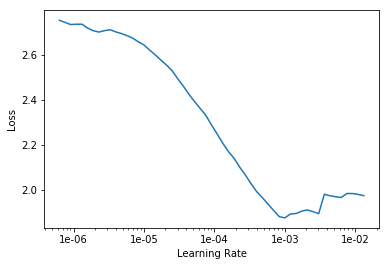

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(10,slice(1e-3),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.089823,0.834785,0.764962,01:04
1,0.795284,0.663601,0.810207,00:59
2,0.614550,0.534712,0.841938,00:59
3,0.534678,0.459977,0.853225,00:59
4,0.484453,0.490251,0.873326,00:59
5,0.523694,0.510499,0.864491,00:59
6,0.461998,0.355288,0.892817,00:59
7,0.453782,0.386681,0.886460,00:59
8,0.395713,0.282365,0.922492,00:59
9,0.342408,0.293172,0.905010,00:59


**Question**: Why do you concat before calling conv2(conv1(x)), not after? [49:50](https://youtu.be/nWpdkZE2_cc?t=2990)

Because if you did your convs before you concat, then there's no way for the channels of the two parts to interact with each other. So remember in a 2D conv, it's really 3D. It's moving across 2 dimensions but in each case it's doing a dot product of all 3 dimensions of a rank 3 tensor (row by column by channel). So generally speaking, we want as much interaction as possible. We want to say this part of the downsampling path and this part of the upsampling path, if you look at the combination of them, you find these interesting things. So generally you want to have as many interactions going on as possible in each computation that you do.

**Question**: How does concatenating every layer together in a DenseNet work when the size of the image/feature maps is changing through the layers? [50:54](https://youtu.be/nWpdkZE2_cc?t=3054)

That's a great question. If you have a stride 2 conv, you can't keep DenseNet-ing. That's what actually happens in a DenseNet is you kind of go like dense block, growing, dense block, growing, dense block, growing, so you are getting more and more channels. Then you do a stride 2 conv without a dense block, and so now it's kind of gone. Then you just do a few more dense blocks and then it's gone. So in practice, a dense block doesn't actually keep all the information all the way through, but just up until every one of these stride 2 convs. There's various ways of doing these bottlenecking layers where you're basically saying hey let's reset. It also helps us keep memory under control because at that point we can decide how many channels we actually want.